In [1]:
import json
import os
import numpy
import pandas
import copy
import conntility, connalysis

from scipy.spatial import distance
from pnagm import util, nngraph, instance, test

from matplotlib import pyplot as plt



In [2]:
config_fn = "../configs/characterization_recursive.json"
plot_out = "plots_lr"
frac_lr = 0.04

with open(config_fn, "r") as fid:
    cfg = json.load(fid)

pts = util.make_points(cfg["make_points"])
pts_df = pandas.DataFrame(pts, columns=["x", "y", "z"])

if not os.path.exists(plot_out):
    os.makedirs(plot_out)

In [3]:
pts_mirrored = pts.copy()
pts_mirrored[:, 1] = numpy.abs(pts_mirrored[:, 1])
pts_modulo = pts.copy()
pts_modulo[:, 1] = numpy.mod(pts[:, 1] + pts[:, 1].min(), pts[:, 1].max())
p_pick = cfg["nngraph"]["p_pick"]

cfg["nngraph"]["p_pick"] = p_pick
M_lcl = nngraph.cand2_point_nn_matrix(pts, **cfg["nngraph"])

cfg["nngraph"]["p_pick"] = p_pick * frac_lr
M_lr = nngraph.cand2_point_nn_matrix(pts_mirrored, **cfg["nngraph"])

Mc = (M_lcl + M_lr).astype(bool).astype(float)

cfg["nngraph"]["p_pick"] = p_pick * frac_lr
M_ls = nngraph.cand2_point_nn_matrix(pts_modulo, **cfg["nngraph"])

Md = (M_lcl + M_ls).astype(bool).astype(float)

Msolo = M_lcl.astype(bool).astype(float)

In [4]:
step_tgt = cfg["instance"]["step_tgt"]
cfg["instance"]["step_tgt"] = step_tgt * (1 + frac_lr)
mdl, _, _ = instance.build_instance(pts, Mc, **cfg["instance"])
print(mdl.sum(axis=1).mean())
cm = conntility.ConnectivityMatrix(mdl, vertex_properties=pts_df.copy())

cfg["instance"]["step_tgt"] = step_tgt * (1 + frac_lr)
mdm, _, _ = instance.build_instance(pts, Md, **cfg["instance"])
print(mdm.sum(axis=1).mean())
cn = conntility.ConnectivityMatrix(mdm, vertex_properties=pts_df.copy())

cfg["instance"]["step_tgt"] = step_tgt
mdl_solo, _, _ = instance.build_instance(pts, Msolo, **cfg["instance"])
print(mdl_solo.sum(axis=1).mean())
cm_solo = conntility.ConnectivityMatrix(mdl_solo, vertex_properties=pts_df.copy())

72.80682142857142
72.07939285714286
63.647392857142854


In [5]:
binsz = 50.0
bin_centers = {}
for axis, sz in zip(["x", "y", "z"], cfg["make_points"]["tgt_sz"]):
    bins = numpy.arange(-sz/2, sz/2 + binsz, binsz)
    bin_centers[axis] = 0.5 * (bins[:-1] + bins[1:])
    dgtz = numpy.digitize(cm.vertices[axis], bins=bins) - 1
    cm.add_vertex_property("binned_" + axis, dgtz)

    dgtz = numpy.digitize(cn.vertices[axis], bins=bins) - 1
    cn.add_vertex_property("binned_" + axis, dgtz)

    dgtz = numpy.digitize(cm_solo.vertices[axis], bins=bins) - 1
    cm_solo.add_vertex_property("binned_" + axis, dgtz)

In [6]:
Nrml = cm.vertices[["binned_x", "binned_y"]].value_counts().unstack()
Nrml = Nrml.reindex(columns=range(len(bin_centers["y"])),
                    index=range(len(bin_centers["x"])))

In [7]:
df = pandas.concat([
    cm.edge_associated_vertex_properties("binned_x"),
    cm.edge_associated_vertex_properties("binned_y"),
    cm._edge_indices
], axis=1, keys=["x", "y", "i"], names=["axis"])

vc = df.groupby([("x", "row"), ("y", "row")])[[("x", "col"), ("y", "col")]].value_counts()

df = pandas.concat([
    cn.edge_associated_vertex_properties("binned_x"),
    cn.edge_associated_vertex_properties("binned_y"),
    cn._edge_indices
], axis=1, keys=["x", "y", "i"], names=["axis"])

vd = df.groupby([("x", "row"), ("y", "row")])[[("x", "col"), ("y", "col")]].value_counts()


df_solo = pandas.concat([
    cm_solo.edge_associated_vertex_properties("binned_x"),
    cm_solo.edge_associated_vertex_properties("binned_y"),
    cm_solo._edge_indices
], axis=1, keys=["x", "y", "i"], names=["axis"])

vc_solo = df_solo.groupby([("x", "row"), ("y", "row")])[[("x", "col"), ("y", "col")]].value_counts()

In [8]:
D = distance.squareform(distance.pdist(pts))
dbins = numpy.arange(1E-6, 1500, 31)
dbin_c = 0.5 * (numpy.array(dbins[:-1]) + numpy.array(dbins[1:]))
Db = numpy.digitize(D, bins=dbins) - 1

n_pairs = numpy.histogram(Db.flat, bins=range(len(dbins)))[0]
n_con = [numpy.histogram(Db[_instance.array], bins=range(len(dbins)))[0]
         for _instance in [cm, cn, cm_solo]]
p_con = [_con / n_pairs for _con in n_con]

p_con = pandas.DataFrame(dict([(_lbl, _data) for _lbl, _data in 
                               zip(["long-range: mirror", "long-range: mod.", "no long-range"], p_con)]),
                        index=dbin_c)

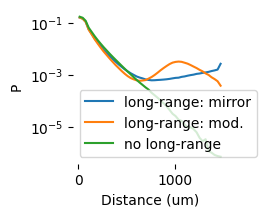

In [9]:
fig = plt.figure(figsize=(2, 2))
ax = fig.gca()

for i in ["long-range: mirror", "long-range: mod.", "no long-range"]:
    ax.plot(p_con[i], label=i)
ax.set_yscale("log")
ax.set_xlabel("Distance (um)")
ax.set_ylabel("P")
ax.set_frame_on(False)
plt.legend()

fig.savefig(os.path.join(plot_out, "lr_1d_con_prob.pdf"))

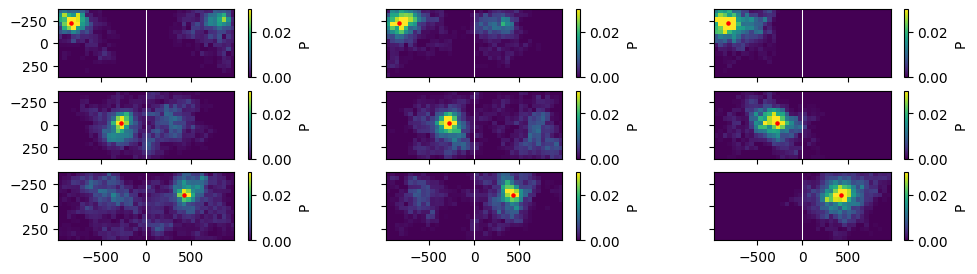

In [10]:
fig = plt.figure(figsize=(12, 3.))
axes = fig.subplots(3, 3, sharex=True, sharey=True).flatten()

ix = [3, 7, 5]
iy = [3, 14, 28]
clim = (0, 0.03)

for _ix, _iy in zip(ix, iy):
    ax = axes[0]
    axes = axes[1:]
    I = vc[_ix][_iy].unstack(fill_value=0)
    I = I.reindex(columns=range(len(bin_centers["y"])),
            index=range(len(bin_centers["x"])),
            fill_value=0) / (Nrml * Nrml[_iy][_ix])



    img = ax.imshow(I, extent=[bin_centers["y"][0],
                        bin_centers["y"][-1],
                        bin_centers["x"][-1],
                        bin_centers["x"][0]],
                        clim=clim)
    ax.scatter(
        bin_centers["y"][_iy],
        bin_centers["x"][_ix],
        s=5,c="red"
    )
    ax.set_ylim(ax.get_ylim())
    ax.plot([0, 0], ax.get_ylim(), color="white", lw=0.75)
    plt.colorbar(img, label="P")

    ax = axes[0]
    axes = axes[1:]
    I = vd[_ix][_iy].unstack(fill_value=0)
    I = I.reindex(columns=range(len(bin_centers["y"])),
            index=range(len(bin_centers["x"])),
            fill_value=0) / (Nrml * Nrml[_iy][_ix])



    img = ax.imshow(I, extent=[bin_centers["y"][0],
                        bin_centers["y"][-1],
                        bin_centers["x"][-1],
                        bin_centers["x"][0]],
                        clim=clim)
    ax.scatter(
        bin_centers["y"][_iy],
        bin_centers["x"][_ix],
        s=5,c="red"
    )
    ax.set_ylim(ax.get_ylim())
    ax.plot([0, 0], ax.get_ylim(), color="white", lw=0.75)
    plt.colorbar(img, label="P")

    ax = axes[0]
    axes = axes[1:]
    I = vc_solo[_ix][_iy].unstack(fill_value=0)
    I = I.reindex(columns=range(len(bin_centers["y"])),
            index=range(len(bin_centers["x"])),
            fill_value=0) / (Nrml * Nrml[_iy][_ix])



    img = ax.imshow(I, extent=[bin_centers["y"][0],
                        bin_centers["y"][-1],
                        bin_centers["x"][-1],
                        bin_centers["x"][0]],
                        clim=clim)
    ax.scatter(
        bin_centers["y"][_iy],
        bin_centers["x"][_ix],
        s=5,c="red"
    )
    ax.set_ylim(ax.get_ylim())
    ax.plot([0, 0], ax.get_ylim(), color="white", lw=0.75)
    plt.colorbar(img, label="P")

fig.savefig(os.path.join(plot_out, "lr_2d_con_prob.pdf"))

In [11]:
all_smplx_model = pandas.concat([
    test.DDtest.simplex_counts_and_controls(_instance)
    for _instance in [cm.matrix, cn.matrix, cm_solo.matrix]
], axis=1, names=["instance"], keys=["long-range: mirror", "long-range: mod.", "no long-range"])

[2025-12-07 16:59:18,704] WARNING: No seed among keyword arguments
[2025-12-07 16:59:51,932] WARNING: No seed among keyword arguments
[2025-12-07 17:00:10,915] WARNING: No seed among keyword arguments


/var/folders/py/wqmt8l2s5zb8fhrxbd_b258w0000gn/T/ipykernel_28331/49136803.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


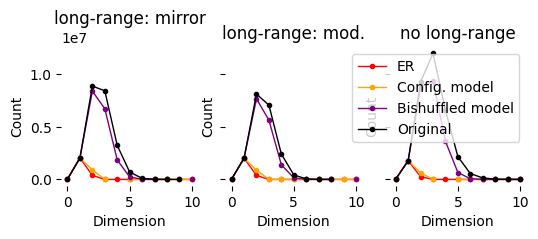

In [12]:
fig = plt.figure(figsize=(6., 1.8))
axes = fig.subplots(1, 3, sharex=True, sharey=True)

cols = {"Original": "black", "ER": "red", "Config. model": "orange", "Bishuffled model": "purple"}

for i, ax in zip(all_smplx_model.columns, axes):
    smplx_model = all_smplx_model[i].unstack(fill_value=0)
    for mdl in smplx_model.index:
        ax.plot(smplx_model.loc[mdl], color=cols[mdl], marker='o', ms=3, lw=1.0, label=mdl)

    ax.set_title(i)
    ax.set_xlabel("Dimension"); ax.set_ylabel("Count")
    ax.set_frame_on(False)
    plt.legend()

fig.savefig(os.path.join(plot_out, "lr_simplices.pdf"))

In [13]:
smpl_list = connalysis.network.topology.list_simplices_by_dimension(cm.matrix)
smpl_list_mod = connalysis.network.topology.list_simplices_by_dimension(cn.matrix)
smpl_list_solo = connalysis.network.topology.list_simplices_by_dimension(cm_solo.matrix)

[2025-12-07 17:00:32,877] INFO: COMPUTE list of simplices by dimension
[2025-12-07 17:00:52,408] INFO: COMPUTE list of simplices by dimension
[2025-12-07 17:01:08,298] INFO: COMPUTE list of simplices by dimension


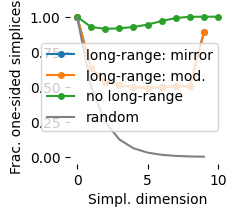

In [15]:
from scipy.stats import binom

ns = numpy.arange(len(smpl_list))
sgn = cm.vertices["y"].values > 0

def fraction_all_one_side(lst):
    sgn_s = sgn[lst].sum(axis=1)
    is_one_side = (sgn_s == 0) | (sgn_s == lst.shape[1])
    return is_one_side.mean()

fig = plt.figure(figsize=(2, 2))
ax = fig.gca()

ax.plot([fraction_all_one_side(_x) for _x in smpl_list], marker='o', ms=4, label="long-range: mirror")
ax.plot([fraction_all_one_side(_x) for _x in smpl_list], marker='o', ms=4, label="long-range: mod.")
ax.plot([fraction_all_one_side(_x) for _x in smpl_list_solo], marker='o', ms=4, label="no long-range")
ax.plot(binom(ns + 1, 0.5).pmf(0) + binom(ns + 1, 0.5).pmf(ns + 1), color="grey", label="random")
ax.set_xlabel("Simpl. dimension")
ax.set_ylabel("Frac. one-sided simplices")
ax.set_frame_on(False)
plt.legend()

fig.savefig(os.path.join(plot_out, "lr_one_sided_simplices.pdf"))

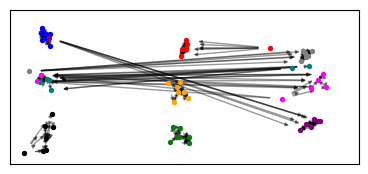

In [ ]:
from networkx import draw_networkx_nodes, draw_networkx_edges
tgt_dim = 6

tgt_x, tgt_y = numpy.meshgrid(numpy.linspace(3, 12, 3).astype(int),
                              numpy.linspace(3, 35, 3).astype(int))

df = pandas.DataFrame({
    "x": cm.vertices["binned_x"].to_numpy()[smpl_list[tgt_dim][:, 3]],
    "y": cm.vertices["binned_y"].to_numpy()[smpl_list[tgt_dim][:, 3]]
})
examples = []
for tgt in zip(tgt_x.flatten(), tgt_y.flatten()):
    match = (df == tgt).all(axis=1)
    examples.append(numpy.random.choice(match.index[match]))

cols = ["black", "teal", "blue", "green", "orange", "red", "purple", "magenta", "grey"]

fig = plt.figure(figsize=(4.5, 2))
ax = fig.gca()

for i, col in zip(examples, cols):
    sub_cm = cm.subpopulation(smpl_list[tgt_dim][i])
    _nx = sub_cm.to_networkx()
    pos = {
        _node: _pos
        for _node, _pos in zip(_nx.nodes, sub_cm.vertices[["y", "x"]].to_numpy())
    }
    draw_networkx_nodes(_nx, pos=pos, node_color=col, node_size=15, linewidths=0)
    draw_networkx_edges(_nx, pos=pos, alpha=0.4, arrowsize=5)
    plt.axis("equal")
    plt.gca().set_xlim([-1050, 1050])
    plt.gca().set_ylim([-450, 450])
fig.savefig("/Users/mwr/Documents/plots/connectome_model/revisions/example_lr_mdl.pdf")

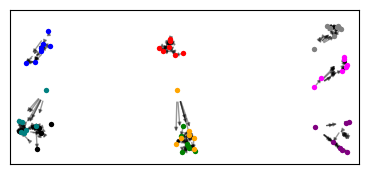

In [ ]:
tgt_dim = 6

df = pandas.DataFrame({
    "x": cm_solo.vertices["binned_x"].to_numpy()[smpl_list_solo[tgt_dim][:, 0]],
    "y": cm_solo.vertices["binned_y"].to_numpy()[smpl_list_solo[tgt_dim][:, 0]]
})
examples = []
for tgt in zip(tgt_x.flatten(), tgt_y.flatten()):
    match = (df == tgt).all(axis=1)
    examples.append(numpy.random.choice(match.index[match]))

cols = ["black", "teal", "blue", "green", "orange", "red", "purple", "magenta", "grey"]

fig = plt.figure(figsize=(4.5, 2))
ax = fig.gca()

for i, col in zip(examples, cols):
    sub_cm = cm_solo.subpopulation(smpl_list_solo[tgt_dim][i])
    _nx = sub_cm.to_networkx()
    pos = {
        _node: _pos
        for _node, _pos in zip(_nx.nodes, sub_cm.vertices[["y", "x"]].to_numpy())
    }
    draw_networkx_nodes(_nx, pos=pos, node_color=col, node_size=15, linewidths=0)
    draw_networkx_edges(_nx, pos=pos, alpha=0.4, arrowsize=5)
    plt.axis("equal")
    plt.gca().set_xlim([-1050, 1050])
    plt.gca().set_ylim([-450, 450])
fig.savefig("/Users/mwr/Documents/plots/connectome_model/revisions/example_lr_ctrl.pdf")